## Panorama Stitching using SuperGlue
SuperGlue network is a Graph Neural Network combined with an Optimal Matching layer that is trained to perform matching on two sets of sparse image features.

***Source Images from Open Adobe Project***
[Adobe Panoramas](https://liquidtelecom.dl.sourceforge.net/project/adobedatasets.adobe/adobe_panoramas.tgz)

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [2]:
# generating the necessary txt file to input for the super glue algorithm
img_name = 'hotel' # set of outdoor images
num_images = 8
# Order of the images. To stitch left and right images as depicted in the below
order = range(num_images -1,0,-1) 
with open('adobe_panorama.txt', 'w') as file:
    for i in order:
        file.write("{img}-{:02}.png {img}-{:02}.png\n".format(i,i-1, img = img_name))

In [3]:
# Running the super glue algorithm on outdoor dataset to match features
"""
    Do not resize the images, 
    If you need to use the extracted keypoints,
    to process the "original" source images.

    Set the parameter to -1 to avoid resizing
    --resize -1
    
    Other parameter can be set as folows,
    to extract the best matching features.
    * Non maximum Suppression Radius = 5
    * Matching Confidence = 0.9
"""
!python match_pairs.py  --resize -1\
                        --superglue outdoor \
                        --max_keypoints 2048 \
                        --nms_radius 5 \
                        --resize_float \
                        --input_dir adobe_panorama/ \
                        --input_pairs adobe_panorama.txt \
                        --output_dir adobe_panorama/output \
                        --viz \
                        --keypoint_threshold 0.05 \
                        --match_threshold 0.9

Namespace(input_pairs='adobe_panorama.txt', input_dir='adobe_panorama/', output_dir='adobe_panorama/output', max_length=-1, resize=[-1], resize_float=True, superglue='outdoor', max_keypoints=2048, keypoint_threshold=0.05, nms_radius=5, sinkhorn_iterations=20, match_threshold=0.9, viz=True, eval=False, fast_viz=False, cache=False, show_keypoints=False, viz_extension='png', opencv_display=False, shuffle=False, force_cpu=False)
Will not resize images
Running inference on device "cuda"
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)
Looking for data in directory "adobe_panorama"
Will write matches to directory "adobe_panorama\output"
Will write visualization images to directory "adobe_panorama\output"
[Finished pair     0 of     7] load_image=0.027 matcher=1.414 viz_match=0.736 total=2.177 sec {0.5 FPS} 
[Finished pair     1 of     7] load_image=0.027 matcher=1.090 viz_match=0.739 total=1.857 sec {0.5 FPS} 
[Finished pair     2 of     7] load_image=0.027 matcher=0.873 vi

In [4]:
#generatig the npz files for extract matching information
npz_files = ["{img}-{:02}_{img}-{:02}_matches.npz".format(i,i-1, img = img_name) for i in order]
for file in npz_files:
    path = 'adobe_panorama/output/'+file
    npz = np.load(path)
print(npz.files)

['keypoints0', 'keypoints1', 'matches', 'match_confidence']


For each keypoint in `keypoints0`, the `matches` array indicates the index of the matching keypoint in `keypoints1`, or `-1` if the keypoint is unmatched.

In [15]:
# extracting information from the npz files 
def loadNPZ(npz_file):    
    npz = np.load('adobe_panorama/output/'+ npz_file)
    point_set1 = npz['keypoints0'][npz['matches']>-1]
    matching_indexes =  npz['matches'][npz['matches']>-1] # -1 if the keypoint is unmatched
    point_set2 = npz['keypoints1'][matching_indexes]
    print("Number of matching points for the findHomography algorithm:")
    print("In left  image:", len(point_set1),"\nIn right image:", len(point_set2))
    return point_set1, point_set2

In [16]:
def pltSourceImages(imageSet):    
    im_left = cv.imread('adobe_panorama/hotel-{:02}.png'.format(imageSet),cv.IMREAD_ANYCOLOR)
    im_right = cv.imread('adobe_panorama/hotel-{:02}.png'.format(imageSet -1),cv.IMREAD_ANYCOLOR)
    
    # Marking the detected features on the two images.
    for point in point_set1.astype(np.int32):
        cv.circle(im_left, tuple(point), radius=8, color=(255, 255, 0), thickness=-1)

    for point in point_set2.astype(np.int32):
        cv.circle(im_right, tuple(point), radius=8, color=(255, 255, 0), thickness=-1)

    fig = plt.figure(figsize = (10,10))
    plt.subplot(121),plt.imshow(im_left, cmap='gray', vmin = 0, vmax = 255)
    plt.subplot(122),plt.imshow(im_right, cmap='gray', vmin = 0, vmax = 255)
    plt.show()

In [17]:
def plotMatches(imageSet):
    plt.figure(figsize=(10,10))
    matched_points = cv.imread('adobe_panorama/output/hotel-{:02}_hotel-{:02}_matches.png'.\
                     format(imageSet, imageSet -1),cv.IMREAD_ANYCOLOR)
    plt.imshow(matched_points, cmap='gray', vmin = 0, vmax = 255)
    plt.show()

Number of matching points for the findHomography algorithm:
In left  image: 230 
In right image: 230


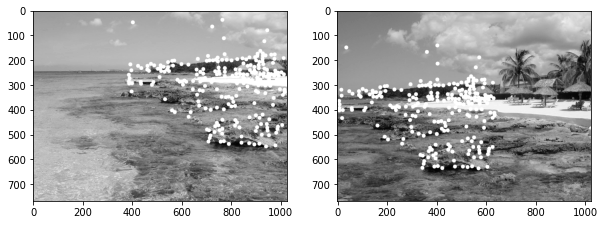

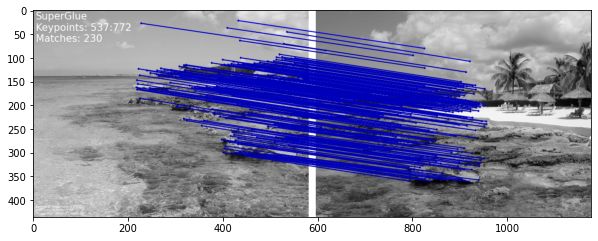

[[ 1.12042290e+00 -3.85874853e-03 -4.23029715e+02]
 [ 3.29399021e-02  1.05885703e+00  9.21255755e+01]
 [ 1.35266098e-04 -4.70113887e-05  1.00000000e+00]]


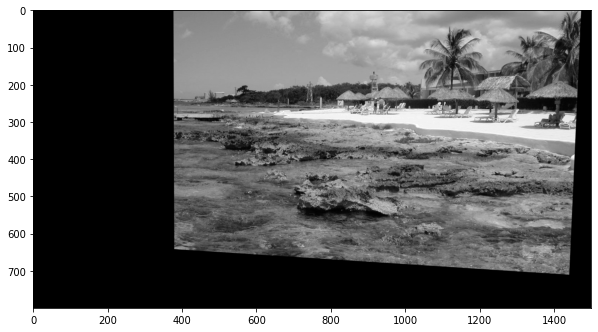

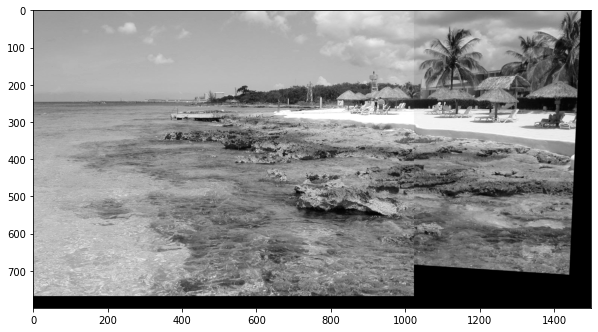

----------------------------------------------------------------------------------------------------
Number of matching points for the findHomography algorithm:
In left  image: 330 
In right image: 330


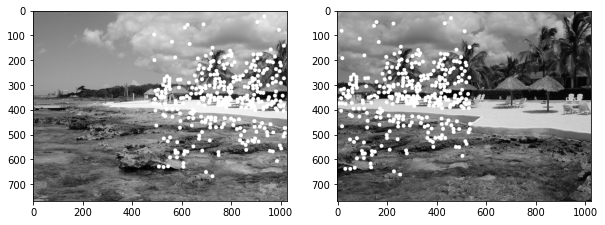

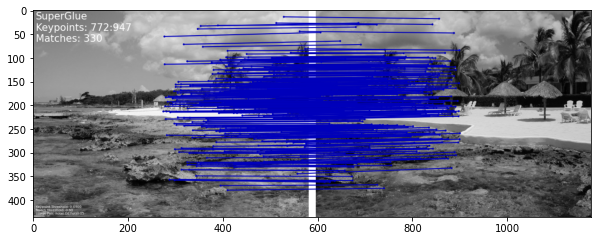

[[ 1.20428734e+00 -1.72684857e-03 -5.76488940e+02]
 [ 5.73748516e-02  1.14559575e+00 -4.67782173e+01]
 [ 2.01826755e-04  2.59683283e-06  1.00000000e+00]]


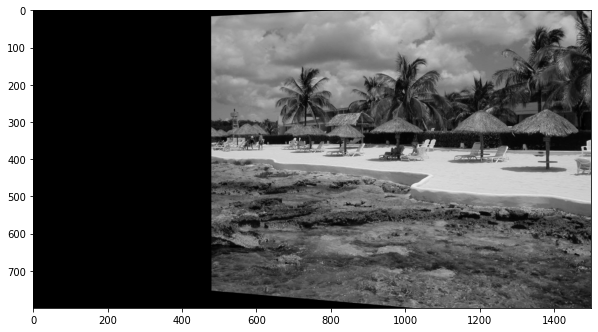

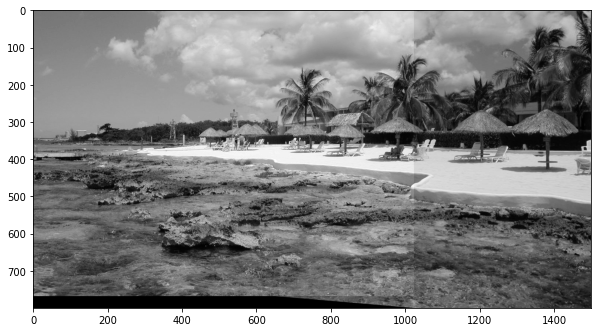

----------------------------------------------------------------------------------------------------
Number of matching points for the findHomography algorithm:
In left  image: 332 
In right image: 332


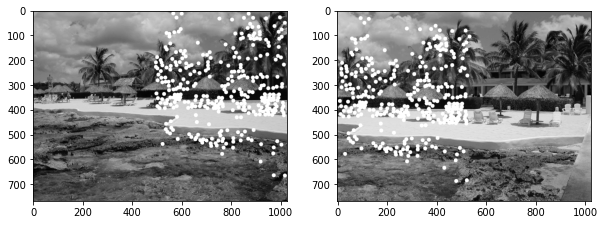

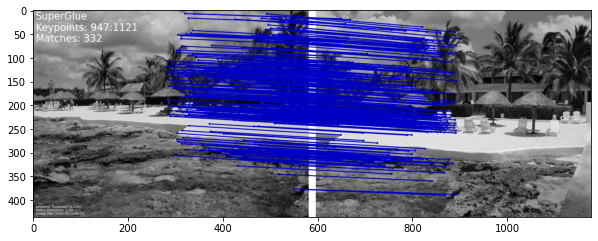

[[ 1.20529130e+00 -3.97636314e-02 -5.74665305e+02]
 [ 9.61719610e-02  1.14190725e+00 -2.98320127e+01]
 [ 2.10996356e-04 -1.87524736e-05  1.00000000e+00]]


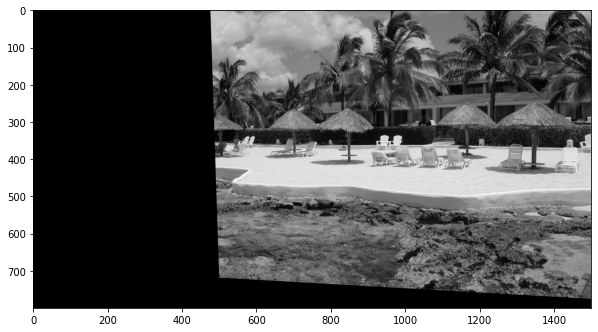

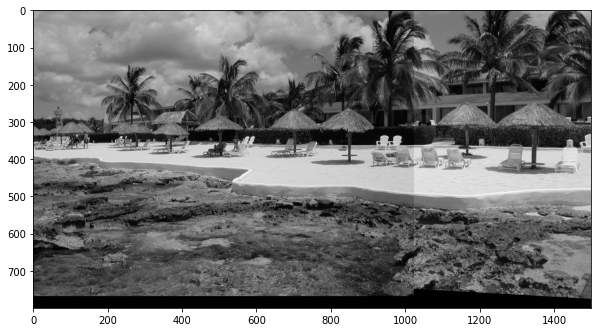

----------------------------------------------------------------------------------------------------
Number of matching points for the findHomography algorithm:
In left  image: 446 
In right image: 446


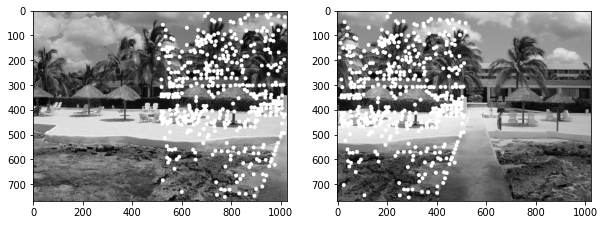

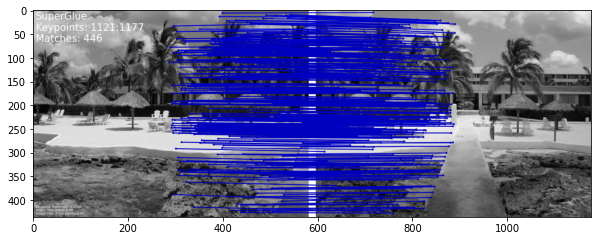

[[ 1.21836173e+00 -1.22659466e-02 -6.06407973e+02]
 [ 8.20461788e-02  1.15661792e+00 -5.39186033e+01]
 [ 2.18624527e-04 -2.87741619e-06  1.00000000e+00]]


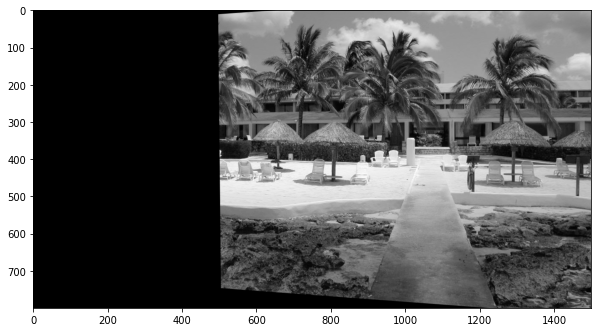

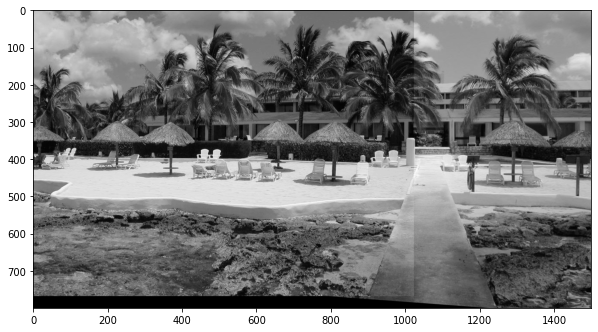

----------------------------------------------------------------------------------------------------
Number of matching points for the findHomography algorithm:
In left  image: 391 
In right image: 391


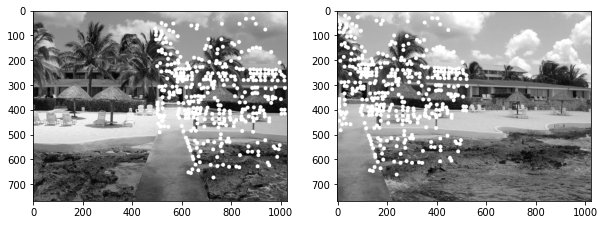

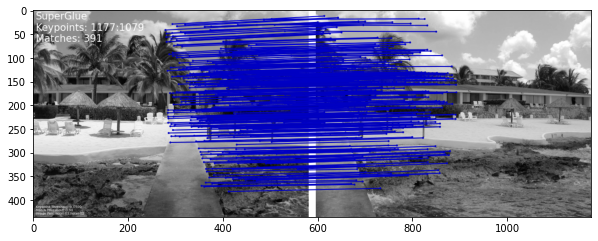

[[ 1.18602377e+00 -1.99411820e-02 -5.77207621e+02]
 [ 7.72441517e-02  1.13917496e+00 -7.23393906e+01]
 [ 1.80395477e-04  1.26435640e-05  1.00000000e+00]]


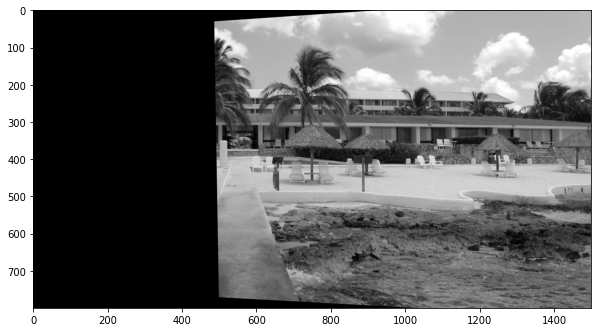

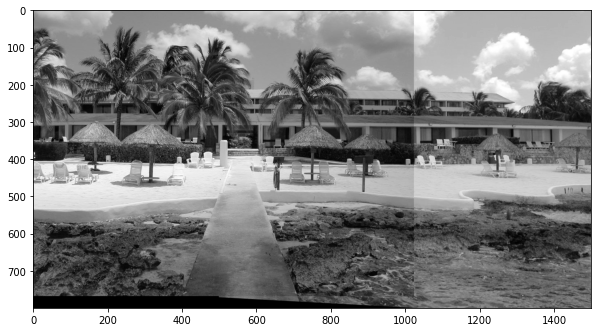

----------------------------------------------------------------------------------------------------
Number of matching points for the findHomography algorithm:
In left  image: 329 
In right image: 329


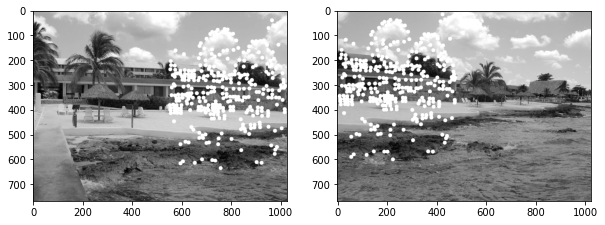

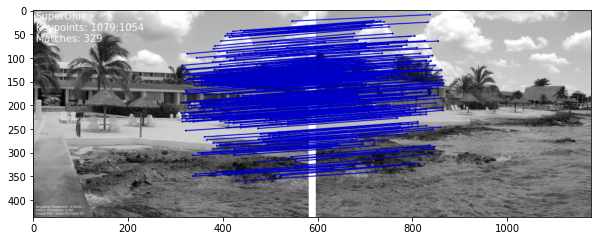

[[ 1.23567967e+00 -5.53333655e-03 -6.66664959e+02]
 [ 7.79843904e-02  1.19080240e+00 -1.06696548e+02]
 [ 2.22012514e-04  2.58951330e-05  1.00000000e+00]]


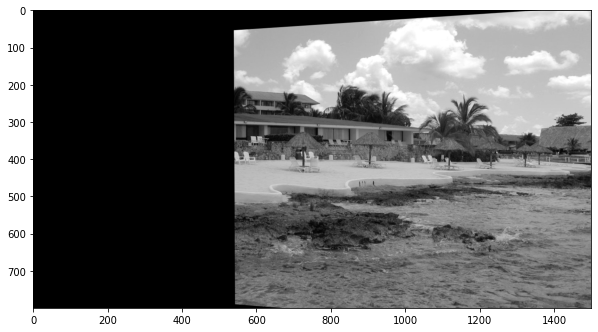

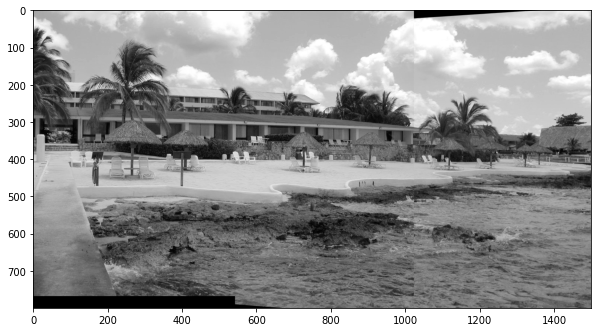

----------------------------------------------------------------------------------------------------


In [24]:
for imgSet in range(num_images-1,1,-1):  
    # loading points
    point_set1, point_set2 = loadNPZ(npz_files[num_images-1 -imgSet])
    pltSourceImages(imgSet)
    plotMatches(imgSet)    
    # getting the required source images
    im_left = cv.imread('adobe_panorama/hotel-{:02}.png'.format(imgSet),cv.IMREAD_ANYCOLOR)
    im_right = cv.imread('adobe_panorama/hotel-{:02}.png'.format(imgSet -1),cv.IMREAD_ANYCOLOR)
    #find Homography between two source images
    H, status = cv.findHomography(point_set1, point_set2, cv.RANSAC, 5.0) 
    # Prints the Homography matrix that transform left image to right image
    print(H) 
    # Applies a homogeneous transformation to an image.
    # To transform the right image to left we need to consider the inverse.
    panorama = cv.warpPerspective(im_right, np.linalg.inv(H), (1500,800)) 
    plt.figure(figsize=(10,10))
    plt.imshow(panorama, cmap='gray', vmin = 0, vmax = 255)
    panorama[0:im_left.shape[0], 0:im_left.shape[1]] = im_left
    plt.figure(figsize=(10,10))
    plt.imshow(panorama, cmap='gray', vmin = 0, vmax = 255)
    plt.show()    
    print("-"*100)